In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [3]:
token_path = "C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Flickr_TextData\\Flickr8k.token.txt"
train_images_path = 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Flickr_TextData\\Flickr_8k.trainImages.txt'
test_images_path = 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Flickr_TextData\\Flickr_8k.testImages.txt'
images_path = 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\'
glove_path = 'C:\\Users\\Raghav\\Downloads\\archive (1)\\glove.6b.200.txt'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [4]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [5]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

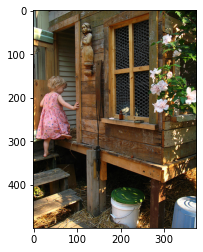

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [6]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+'\\'+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [7]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [8]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [9]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [10]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [12]:
img

['C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1002674143_1b742ab4b8.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1003163366_44323f5815.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1007129816_e794419615.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1007320043_627395c3d8.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1009434119_febe49276a.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1012212859_01547e3f17.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1015118661_980735411b.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images

In [11]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [12]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [13]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [14]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [15]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [16]:
embeddings_index = {} 
gpath='C:\\Users\\Raghav\\Downloads\\archive (1)'
f = open(os.path.join(gpath,'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [17]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
model = InceptionV3(weights='imagenet')

In [19]:
model_new = Model(model.input, model.layers[-2].output)

In [20]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [23]:
train_img

['C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1002674143_1b742ab4b8.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1003163366_44323f5815.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1007129816_e794419615.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1007320043_627395c3d8.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1009434119_febe49276a.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1012212859_01547e3f17.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images\\1015118661_980735411b.jpg',
 'C:\\Users\\Raghav\\Downloads\\archive\\Flickr_Data\\Flickr_Data\\Images

In [21]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [22]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [23]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

{'1000268201_693b08cb0e.jpg': array([0.12277624, 0.3329494 , 0.7527175 , ..., 0.21939665, 0.30216402,
        0.40283203], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.73668385, 0.591132  , 0.18194194, ..., 0.16030261, 0.34144673,
        0.90831614], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([0.3735189 , 0.24596637, 0.96353024, ..., 1.1459359 , 0.26540142,
        0.01983151], dtype=float32),
 '1003163366_44323f5815.jpg': array([0.4860306 , 0.29218286, 0.3143687 , ..., 0.98254865, 0.2810809 ,
        0.22330043], dtype=float32),
 '1007129816_e794419615.jpg': array([0.21595302, 0.15582052, 0.2947709 , ..., 0.4056498 , 0.16532019,
        0.374169  ], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.17231032, 0.49808353, 0.21576957, ..., 0.09676231, 1.2298485 ,
        0.542142  ], dtype=float32),
 '1009434119_febe49276a.jpg': array([0.5346092 , 1.3676208 , 0.7804354 , ..., 0.3946374 , 0.88772327,
        1.0728823 ], dtype=float32),
 '1012212859_01547e3f17.jpg

In [25]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
epochs = 1
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 620s 308ms/step - loss: 4.1501


In [27]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

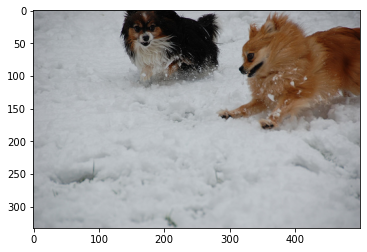

Greedy Search: a dog is running through the snow


In [30]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
raghav=greedySearch(image)

print("Greedy Search:",greedySearch(image))

In [31]:
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 
  
# This module is imported so that we can  
# play the converted audio 

mytext=raghav
  
# Language in which you want to convert 
language = 'en'
  
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
myobj = gTTS(text=mytext, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("welcome.mp3") 
  
# Playing the converted file 
os.system("welcome.mp3") 

0